## IMDB review sentiment Analysis


#### Μέλη Ομάδας:
- Ευάγγελος Λευτάκης : 3200093
- Ρέα Σκλήκα : 3210181
- Σοφία-Ζωή Σωτηρίου : 3210192

### Dependencies

In [ ]:
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U tensorflow
!pip install -U scikit-learn

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

### 1st Part

First We Prepare the train and test data and create a binary representation of it.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

(x_train_imdb, y_train), (x_test_imdb, y_test) = tf.keras.datasets.imdb.load_data()


word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])

binary_vectorizer = CountVectorizer(binary=True, min_df=100,stop_words="english")
x_train = binary_vectorizer.fit_transform(x_train_imdb)
x_test = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)
x_train = x_train.astype(int)
x_test = x_test.astype(int)

# x_train = x_train.toarray()
# x_test = x_test.toarray()



Vocabulary size: 3563


#### Logistic Regression:


In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import issparse
from sklearn.metrics import classification_report

class LogisticRegression():
   

    def __init__(self,epochs=20,learning_rate=0.001,threshold=0.5, regularization_factor=1):
        self.epochs=epochs;
        self.learning_rate=learning_rate
        self.weights = np.array([])
        self.threshold=threshold
        self.regularization_factor = regularization_factor
        
    
    def set_threshold(self,value):
        self.threshold = value
    def sigmoid(self , t):
        return 1/(1+np.exp(-t))


    def fit(self,x_train_input,y_train_input,learning_curve=False):
        ''' '''
        feature_vector_length = x_train_input.shape[1]
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        x_dev = x_dev.toarray()
        

        training_learning_curve_data =[]
        dev_learning_curve_data = []

        # We prepare the array by adding a column of 1s
        # for the w0 weight
        x_train = x_train.toarray()
        ones_column = np.ones(x_train.shape[0])
        x_train = np.insert(x_train, 0, ones_column, axis=1)
        self.weights = self.initialize_weights(feature_vector_length)
        # We prepare the extra data used
        best_f1_score = 0
        epochs_without_improvement = 0
        for epoch in range(self.epochs):
            # np.random.shuffle(x_train)
            for i in range(x_train.shape[0]):
                x_i = x_train[i-1]
                y_i = y_train[i-1]

                self.update_weights(x_i,y_i)
            if(learning_curve):
                x_train_temp = np.delete(x_train, 0, axis=1)
                training_learning_curve_data.append(accuracy_score(y_train,self.predict(x_train_temp)))
                dev_learning_curve_data.append(accuracy_score(y_dev,self.predict(x_dev)))
            f1 = f1_score(y_dev, self.predict(x_dev))
            
            if f1 > best_f1_score:
                best_f1_score = f1
                # best_epoch = epoch
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= 20 :
                    break
       
        x_train = np.delete(x_train, 0, axis=1)                 #remove 1s column again (needed previously for w0)

        return self.evaluate(y_train,self.predict(x_train)),training_learning_curve_data,dev_learning_curve_data

    


        
    
    def predict(self, x_test):
        if issparse(x_test):
            x_test = x_test.toarray()
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            predicted_class = 1 if probability_positive >= self.threshold else 0
            y_test_predicted.append(predicted_class)

        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)

    def predict_prob(self, x_test):
        if issparse(x_test):
            x_test = x_test.toarray()
        ones_column = np.ones(x_test.shape[0])
        x_test = np.insert(x_test, 0, ones_column, axis=1)#insert 1 in x_vector for w0

        y_test_predicted = []

        for test_case in x_test:
            probability_positive =  self.sigmoid(np.dot(self.weights,test_case))
            y_test_predicted.append([probability_positive,(1-probability_positive)])
        x_test = np.delete(x_test, 0, axis=1)
        return np.array(y_test_predicted)


    @staticmethod
    def initialize_weights(size):
        '''We Initialize the weights with random values with a mean of 0 and a standard deviation of 0.01
          This is a common practice to prevent the weights from being too large at the begining '''
        return np.random.randn(size+1) * 0.01

    def update_weights(self,x_test,y_test):
        predicted_prob = self.sigmoid(np.dot(self.weights,x_test))
        gradient = ((y_test - predicted_prob) * x_test)
        self.weights = (1 - 2*self.regularization_factor*self.learning_rate) * self.weights + self.learning_rate * gradient 
    
    def evaluate(self, y_true, y_predicted):
        precision = precision_score(y_true, y_predicted)
        recall = recall_score(y_true, y_predicted)
        f1 = f1_score(y_true, y_predicted)

        print(classification_report(y_true, y_predicted))
        print("Threshold: "+str(self.threshold))
        return np.array([precision,recall,f1])
    

    def generate_pr_curve(self, x_train_input,y_train_input,size=20):
        currentThreshold = 0
        percisions=[]
        recalls=[]
        for i in range(size):
            currentThreshold += 1./size
            if (currentThreshold>0.3 and currentThreshold<0.75):
                self.set_threshold(currentThreshold)
                fit_pr = self.fit(x_train_input , y_train_input)
                percisions.append(fit_pr[0])
                recalls.append(fit_pr[1])
        print(percisions)
        plt.plot(recalls,percisions ,label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Diagram')
        plt.legend()
        plt.show()


#### Results
Here we try out the Logistic Regression learning algorithm

In [49]:
LogReg = LogisticRegression(100,threshold=0.6, regularization_factor=0.001)
LogReg.fit(x_train,y_train)
#LogReg.generate_pr_curves()
y_predicted = LogReg.predict(x_test)
print()
LogReg.evaluate(y_test,y_predicted)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9969
           1       0.93      0.86      0.89     10031

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Threshold: 0.6
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     12500
           1       0.90      0.82      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000

Threshold: 0.6


array([0.90005288, 0.81696   , 0.85649585])

#### Naive Bayes:

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#

class NaiveBayes: 
    def __init__(self):
            self.probabilityC1= None #probabilityC0 = 1 -probabilityC1
            self.boundProbabilityC0 = None 
            self.boundProbabilityC1 = None

    def fit(self, x_train_input, y_train_input): 
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]

        numberOfExamples = x_train.shape[0]
        numberOfFeatures = x_train.shape[1]
        x_train = x_train.toarray()
        #y_train = y_train.flatten()

        positiveReviews = 0
        for label in y_train: 
            if label == 1: 
                positiveReviews += 1 

        self.probabilityC1 = positiveReviews / len(y_train)

        '''
        C0: P( X(i) = 0 | C = 0) and C1 = P ( X(i) = 0 | C = 1)
        P( X(i) = 1 | C = 0) = 1 - P( X(i) = 0 | C = 0) and P( X(i) = 1 | C = 1) = P( X(i) = 0 | C = 1)
        '''
        self.boundProbabilityC0 = np.zeros(numberOfFeatures)  
        self.boundProbabilityC1 = np.zeros(numberOfFeatures)
        for i in range(numberOfFeatures): 

            #For every word that is not on a review add to the array correspnding to the review result of the example 
            for j in range(numberOfExamples):  
                if y_train[j] == 0 and x_train[j][i] == 0: 
                    self.boundProbabilityC0[i] += 1 
                elif y_train[j] == 1 and x_train[j][i] == 0: 
                    self.boundProbabilityC1[i] += 1 
        """
        Adding Laplace estimator with an alpha value of 1 
        """
        self.boundProbabilityC0 = [x + 1 / (numberOfExamples - positiveReviews + x) for x in self.boundProbabilityC0] 
        self.boundProbabilityC1 = [x + 1 / (positiveReviews+ x) for x in self.boundProbabilityC1]
        print("Done!")

    def predict(self, x_test, y_test):
        prediction = list()
        c1 = self.boundProbabilityC1
        c0 = self.boundProbabilityC0
        numberOfFeatures = x_test.shape[1]
        x_test = x_test.toarray()

        for x in range(x_test.shape[0]): 
            positiveReviewProbability = self.probabilityC1 
            negativeReviewProbability = (1 - self.probabilityC1)

            for y in range(numberOfFeatures):
                if x_test[x][y] == 0 and y_test[x] == 0: 
                    negativeReviewProbability = round(negativeReviewProbability * self.boundProbabilityC0[y], 2)
                elif  x_test[x][y] == 1 and y_test[x] == 0: 
                    negativeReviewProbability = round(negativeReviewProbability * (1 - self.boundProbabilityC0[y]), 2)
                elif  x_test[x][y] == 0 and y_test[x] == 1:
                    positiveReviewProbability = round(positiveReviewProbability * self.boundProbabilityC1[y], 2)
                elif  x_test[x][y] == 1 and y_test[x] == 1:
                    positiveReviewProbability = round(positiveReviewProbability * (1 - self.boundProbabilityC1[y]), 2)

            if positiveReviewProbability > negativeReviewProbability: 
                prediction.append(1)
            elif negativeReviewProbability > positiveReviewProbability:
                prediction.append(0)

        return np.array(prediction)
    
    def evaluate(self, y_true, y_predicted):
        accuracy = accuracy_score(y_true, y_predicted)
        print("Accuracy:", accuracy)

        precision = precision_score(y_true, y_predicted)
        print("Precision:", precision)

        # Compute recall
        recall = recall_score(y_true, y_predicted)
        print("Recall:", recall)

        # Compute F1 score
        f1 = f1_score(y_true, y_predicted)
        print("F1 Score:", f1)
        return np.array([precision,recall])
    

    


##### Results:

In [ ]:
NB = NaiveBayes()
NB.fit(x_train,y_train)
y_predicted = NB.predict(x_test, y_test)

NB.evaluate(y_test,y_predicted)


#### [AdaBoost:](Machine-Learning-Algorithms/AdaBoost.py)

In [61]:
import numpy as np
import random as random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class AdaBoost:
    def __init__(self):
        self.M = None
        self.models = []
        self.weights = []
    
    def fit (self, x_train_input, y_train_input, M):
        split_index = int(0.8 * x_train_input.shape[0])  # 80% for training, 20% for dev
        x_train, y_train = x_train_input[:split_index], y_train_input[:split_index]
        x_dev, y_dev= x_train_input[split_index:], y_train_input[split_index:]
        x_train = x_train.toarray()
    
        self.M = M
        # first all samples get the same weight, 1/total number of examples
        # that makes the samples all equally important
        sample_weights = np.ones(x_train.shape[0]) * (1 / x_train.shape[0])
        for m in range(M):
            stump = CreateStump()
            stump.fit( x_train, y_train, sample_weights)
            sample_weights = stump.weights
            self.models.append(stump)
            distribution = list(np.shape(sample_weights) )
            distribution[0] = sample_weights[0]
            for i in range (1,len(sample_weights)):
                distribution.append(distribution[i-1] + sample_weights[i])
            # make a new empty dataset the same size as the original and pick a random number [0..1]
            # and see where that number falls when the sample weights are use like a distribution
            # we fill the new dataset with those values 
            newDataset = np.zeros_like(x_train)
            temp_y = np.zeros_like(y_train)
            for i in range (x_train.shape[0]):
                number = random.random()
                for k in range (x_train.shape[0]):
                    if number <= distribution[k]:
                        for j in range (x_train.shape[1]):
                            newDataset[i][j] = x_train[k][j]
                        sample_weights[i] = sample_weights[k]
                        temp_y += y_train[k]
                        break 
            # normalize the weights so they all add up to 1
            sum = np.sum(sample_weights)
            for i in range(len(sample_weights)):
                self.weights.append( sample_weights[i]/sum) 
            x_train = np.copy(newDataset)
            y_train = np.copy(temp_y)
        y_dev_predicted = self.predict(x_dev)
        return self.evaluate(y_dev_predicted, y_dev)

    def predict(self, x_test):
        x_test = x_test.toarray()
        
        predictions = np.zeros(x_test.shape[0])
        stump_says = np.zeros(len(self.models))

        for i, stump in enumerate(self.models):
            # Get predictions from each stump
            stump_pred = stump.predict(x_test)
            stump_says[i] = stump.amountOfSay
            # Update overall predictions based on the stump's amount of say
            predictions += stump_pred * stump_says[i]

        # Final prediction is based on the sign of the weighted sum
        final_predictions = np.sign(predictions)

        return final_predictions
    
    def evaluate(self, y_true, y_predicted):
        nan_indices1 = np.isnan(y_true)
        if np.any(nan_indices1):
            # Handle NaN values (e.g., remove or replace them)
            y_true = np.nan_to_num(y_true)
        nan_indices2 = np.isnan(y_predicted)
        if np.any(nan_indices2):
            # Handle NaN values (e.g., remove or replace them)
            y_predicted = np.nan_to_num(y_predicted)
            
        accuracy = accuracy_score(y_true, y_predicted)
        print("Accuracy:", accuracy)

        precision = precision_score(y_true, y_predicted)
        print("Precision:", precision)

        # Compute recall
        recall = recall_score(y_true, y_predicted)
        print("Recall:", recall)

        # Compute F1 score
        f1 = f1_score(y_true, y_predicted)
        print("F1 Score:", f1)


            


class CreateStump:
    def __init__(self):
        self.amountOfSay = None
        self.word = None
        self.weights = []

    def fit(self, x, y, w):
        min = float('inf')
        for word_index in range(x.shape[1]):           
            total_error = 0         # the total error of a stump is the sum of the weights associated with the incorrectly classed samples
            cor_pos = 0             # correctly positive
            incor_pos = 0           # incorrectly positive
            cor_neg = 0             # correctly negative
            incor_neg = 0           # incorrectly negative
            for sample_index in range(x.shape[0]):
                if x[sample_index][word_index] == 1 & y[sample_index] == 1:
                    cor_pos += 1
                elif x[sample_index][word_index] == 1 & y[sample_index] == 0:
                    incor_pos += 1
                    total_error += w[sample_index]
                elif x[sample_index][word_index] == 0 & y[sample_index] == 0:
                    cor_neg += 1
                else:
                    incor_neg += 1
                    total_error += w[sample_index]
            pos_total = cor_pos + incor_pos
            neg_total = cor_neg + incor_neg
            total = x.shape[0]
            epsilon = 1e-10  # Small epsilon value to avoid division by zero
            gini_index = ((pos_total)/total)*(1-(cor_pos/(pos_total + epsilon))**2+(incor_pos/(pos_total + epsilon))**2)+((neg_total)/total)*(1-(cor_neg/(neg_total + epsilon))**2+(incor_neg/(neg_total + epsilon))**2)
            if gini_index < min:
                self.amountOfSay = 1/2 * np.log((1-total_error)/(total_error+epsilon))      
                self.word = word_index
        # now we need to decrease the sample weights for all the correctly classified samples
        # and increase the sample weights for all the incorrectly classifies samples
        for sample_index in range(x.shape[0]):
            if (x[sample_index][self.word] == y[sample_index]):
                w[sample_index] = w[sample_index] * np.exp(-self.amountOfSay)
            else:   
                w[sample_index] = w[sample_index] * np.exp(self.amountOfSay)
        # normalize the weights so they all add up to 1
        sum = np.sum(w)
        for i in range(len(w)):
            self.weights.append(w[i]/sum) 

    def predict(self, x_test):
        # Make predictions using the chosen word index
        # Convert predictions to binary (0 or 1)
        stump_pred_binary = np.where(x_test[1][self.word] >= 0.5, 1, 0)

        return stump_pred_binary

##### Results:

In [62]:
AB = AdaBoost()
AB.fit(x_train,y_train, 5)

y_predicted = AB.predict(x_test)

AB.evaluate(y_test,y_predicted)

C:\Users\User\AppData\Local\Temp\ipykernel_15284\903272839.py:130: RuntimeWarning: invalid value encountered in log
  self.amountOfSay = 1/2 * np.log((1-total_error)/(total_error+epsilon))


Accuracy: 0.5062
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 2:
In this Part we are going to compare the algorithms we wrote to the ones given from the sci-kit learn library

#### Stats

In [60]:
from sklearn.metrics import roc_curve as skroc_curve
from sklearn.metrics import roc_auc_score

# Precision Recall Curve
def pr_curves(classifiers,data,size=20):
    currentThreshold = 0
    precisions1 = []
    recalls1 = []
    precisions2 = []
    recalls2 = []
    
    classifier1 = classifiers[0]
    classifier2 = classifiers[1]

    for i in range(size):
        currentThreshold += 1./size
        if (currentThreshold>0.3 and currentThreshold<0.75):
            classifier1.set_threshold(currentThreshold)
            results = classifier1.evaluate(data[1],classifier1.predict(data[0]))
            recalls1.append(results[0])
            precisions1.append(results[1])
    currentThreshold = 0
    for i in range(size):
        currentThreshold += 1./size
        if (currentThreshold>0.3 and currentThreshold<0.75):
            y_pred_proba = classifier2.predict_proba(data[0])[:, 1]  # Probability estimates for the positive class
            y_pred_custom_threshold = (y_pred_proba > currentThreshold).astype(int)
            recalls2.append(recall_score(data[1],y_pred_custom_threshold))
            precisions2.append(precision_score(data[1],y_pred_custom_threshold))

    
    plt.plot(recalls1, precisions1 ,label='our curve')
    plt.plot(recalls2, precisions2 ,label='sci-kit learn')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Diagram')
    plt.legend()
    plt.show()


def roc_curve(classifiers,data):
    classifier1=classifiers[0]
    classifier2=classifiers[1]



    fpr1, tpr1, thresh1 = skroc_curve(data[1], classifier1.predict_prob(data[0])[:,0],pos_label=1)
    fpr2, tpr2, thresh2 = skroc_curve(data[1], classifier2.predict_proba(data[0])[:,1], pos_label=1)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = skroc_curve(data[1], random_probs, pos_label=1)
    auc_score1 = roc_auc_score(data[1], classifier1.predict_prob(data[0])[:,0])
    auc_score2 = roc_auc_score(data[1], classifier2.predict_proba(data[0])[:,1])
    plt.plot(fpr1, tpr1, linestyle='--',color='purple', label='Our Logistic Regression, AUC='+str(auc_score1))
    plt.plot(fpr2, tpr2, linestyle='--',color='blue', label='Sci kit learn, AUC ='+str(auc_score2))
    plt.plot(p_fpr, p_tpr, linestyle='--', color='green')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();

def learning_curve(learning_data,title):
    if (len(learning_data)>0):
        plt.plot(range(len(learning_data)), learning_data, label = title)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend(loc='best')
        plt.show();

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      9969
           1       0.94      0.86      0.90     10031

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Threshold: 0.6


c:\Users\vleft\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


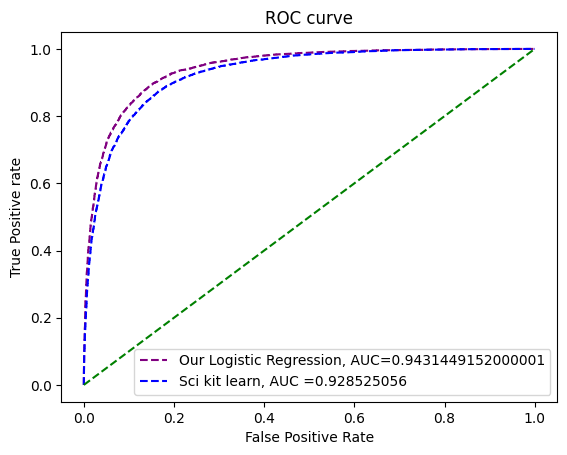

<function print>

In [61]:
from sklearn.linear_model import LogisticRegression as skLogReg

LogReg1 = LogisticRegression(100,threshold=0.6, regularization_factor=0.001)
LogReg2 = skLogReg(max_iter=100)

fit_eval, train_learning_curve_data, dev_learning_curve_data = LogReg1.fit(x_train,y_train,learning_curve=True)
LogReg2.fit(x_train,y_train)


# print(LogReg1.predict_prob(x_test))
# print(LogReg2.predict_proba(x_test))
# pr_curves([LogReg1, LogReg2],[x_train,y_train],size=20)
roc_curve([LogReg1,LogReg2], [x_test,y_test])
learning_curve(train_learning_curve_data, "Train Data Learning Curve")
learning_curve(dev_learning_curve_data, "Dev Data Learning Curve")
print
# LogReg.fit(x_train,y_train)

# classification_report(y_test,LogReg.predict(x_test))